#### listの扱い

In [2]:
from pathlib import Path

In [3]:

with open("../data/dev.list") as f:
        utt_ids = [utt_id.strip() for utt_id in f]

In [4]:
print(utt_ids)

['Seikatsu32_J-I__000080', 'Seikatsu43_B-SI_000090', 'Seikatsu11_K-KE_000070', 'Seikatsu11_E-I__000010', 'Seikatsu04_D-TA_000020', 'Seikatsu03_B-NE_000020', 'Seikatsu14_F-U__000020', 'Seikatsu08_b2-t2o2_000010', 'Seikatsu03_K-O__000040', 'Seikatsu12_H-I__000020', 'Seikatsu04_C-SO_000020', 'Seikatsu04_C-RA_000060', 'Seikatsu08_b2-m2e2_000010', 'Seikatsu43_A-U__000110', 'Seikatsu12_I-A__000080', 'Seikatsu04_C-U__000010', 'Seikatsu34_B-SA_000030', 'Seikatsu23_B-SU_000120', 'Seikatsu03_K-MA_000050', 'Seikatsu14_B-NI_000010', 'Seikatsu03_E-KI_000100', 'Seikatsu01_I-KI_000100', 'Seikatsu12_N-U__000070', 'Seikatsu43_A-KO_000090', 'Seikatsu07_E-U__000010', 'Seikatsu33_A-I__000100', 'Seikatsu08_a2-SA_000110', 'Seikatsu06_B-A__000020', 'Seikatsu21_B-KA_000070', 'Seikatsu14_F-U__000030', 'Seikatsu14_B-FU_000070', 'Seikatsu23_B-TU_000100', 'Seikatsu33_C-I__000010', 'Seikatsu11_A-U__000060', 'Seikatsu31_F-O__000050', 'Seikatsu03_F-KO_000010', 'Seikatsu34_B-KE_000020', 'Seikatsu32_I-O__000070', 'Sei

In [15]:
wav_files = [Path("./downloads/hfc_men") / "all" / f"{utt_id}.wav" for utt_id in utt_ids]
lab_files = [Path("./downloads/hfc_men-label/all") / f"{utt_id}.lab" for utt_id in utt_ids]

In [16]:
print(wav_files)
print(lab_files)

[PosixPath('downloads/hfc_men/all/Seikatsu32_J-I__000080.wav'), PosixPath('downloads/hfc_men/all/Seikatsu43_B-SI_000090.wav'), PosixPath('downloads/hfc_men/all/Seikatsu11_K-KE_000070.wav'), PosixPath('downloads/hfc_men/all/Seikatsu11_E-I__000010.wav'), PosixPath('downloads/hfc_men/all/Seikatsu04_D-TA_000020.wav'), PosixPath('downloads/hfc_men/all/Seikatsu03_B-NE_000020.wav'), PosixPath('downloads/hfc_men/all/Seikatsu14_F-U__000020.wav'), PosixPath('downloads/hfc_men/all/Seikatsu08_b2-t2o2_000010.wav'), PosixPath('downloads/hfc_men/all/Seikatsu03_K-O__000040.wav'), PosixPath('downloads/hfc_men/all/Seikatsu12_H-I__000020.wav'), PosixPath('downloads/hfc_men/all/Seikatsu04_C-SO_000020.wav'), PosixPath('downloads/hfc_men/all/Seikatsu04_C-RA_000060.wav'), PosixPath('downloads/hfc_men/all/Seikatsu08_b2-m2e2_000010.wav'), PosixPath('downloads/hfc_men/all/Seikatsu43_A-U__000110.wav'), PosixPath('downloads/hfc_men/all/Seikatsu12_I-A__000080.wav'), PosixPath('downloads/hfc_men/all/Seikatsu04_C-U_

#### サンプリングレートの確認 & データ数値型の確認

In [215]:
import librosa

# file_path = '../../test_tacotron2/downloads/jsut_ver1.1/basic5000/wav/BASIC5000_0001.wav'
file_path = '../downloads/hfc_men/all/Seikatsu01_A-A__000010.wav'

# 音声データとサンプリングレートの取得
audio_data, sr = librosa.load(file_path)
# リサンプリング
x = librosa.resample(audio_data, orig_sr=sr, target_sr=24000)

# サンプリングレートとデータのサンプル数を表示
print(f"The sampling rate of the audio file is: {sr} Hz")
print(audio_data.shape)
print(x.shape)

The sampling rate of the audio file is: 22050 Hz
(94792,)
(103175,)


In [216]:
from scipy.io import wavfile
import numpy as np

_sr, x = wavfile.read(file_path)
if x.dtype in [np.int16, np.int32]:
    x = (x / np.iinfo(x.dtype).max).astype(np.float64)

print("samplerate is : " + str(_sr))
print("datatype is : " + str(x.dtype))

samplerate is : 48000
datatype is : float64


/var/folders/gs/nm1_2m6x6dsfq_1hwx0k12nc0000gn/T/ipykernel_68901/1522273109.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, x = wavfile.read(file_path)


#### メルスペクトログラムの調整をhfc版に置き換える : 音素アライメントが存在しない場合には一定数のframeで無音期間を切り取る必要がある

In [217]:
import librosa
import numpy as np
from nnmnkwii.io import hts
from nnmnkwii.preprocessing import mulaw_quantize
from scipy.io import wavfile
from dsp import logmelspectrogram
from openjtalk import pp_symbols, text_to_sequence
from util import pad_1d
import matplotlib.pyplot as plt

In [218]:
wav_file = "../downloads/hfc_men/all/Seikatsu01_B-A__000050.wav"
# wav_file = "../../test_tacotron2/downloads/jsut_ver1.1/basic5000/wav/BASIC5000_0001.wav"
lab_file = "../downloads/hfc_men-label/all/Seikatsu01_B-A__000050.lab"
# lab_file = "../../test_tacotron2/downloads/jsut-label/labels/basic5000/BASIC5000_0001.lab"

# assert wav_file.stem == lab_file.stem
labels = hts.load(lab_file) 
PP = pp_symbols(labels.contexts) 
in_feats = np.array(text_to_sequence(PP), dtype=np.int64)

_sr, x = wavfile.read(wav_file) 
if x.dtype in [np.int16, np.int32]:
    x = (x / np.iinfo(x.dtype).max).astype(np.float64) #サンプル値を正規化 ＝ hfcaptain:int32 => to float64
x = librosa.resample(x, orig_sr=_sr, target_sr=sr)
out_feats = logmelspectrogram(x, sr) #メルスペクトログラムを計算

assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1]
start_frame = 20
out_frame = -20
out_feats_cut = out_feats[20:-20]

/var/folders/gs/nm1_2m6x6dsfq_1hwx0k12nc0000gn/T/ipykernel_68901/1985361867.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, x = wavfile.read(wav_file)


In [219]:
x_cut = x[int(start_frame * 0.0125 * sr) :]
length = int(sr * 0.0125) * out_feats_cut.shape[0]
x_cut = pad_1d(x_cut, length) if len(x) < length else x_cut[:length] # 無音期間が足りない場合にはpaddingして、多い場合には切り出す

In [220]:
print("before cut frame is : " + str(out_feats.shape[0]))
print("cutted frame is : " + str(out_feats_cut.shape[0]))

before cut frame is : 277
cutted frame is : 237


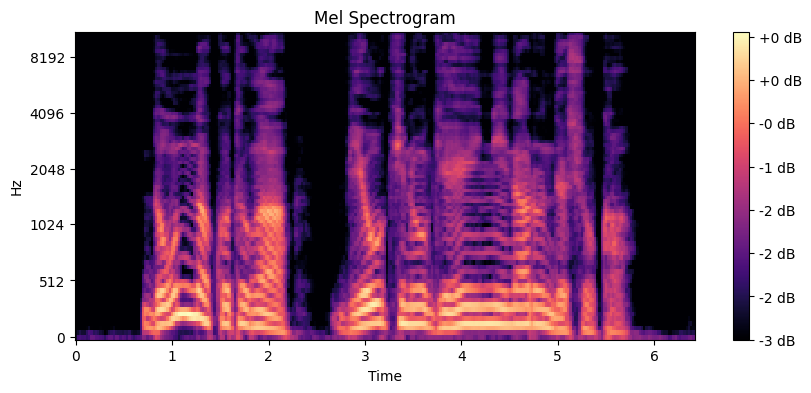

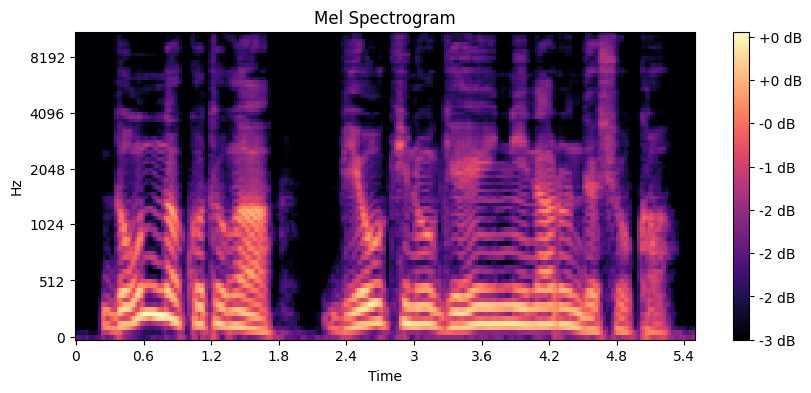

In [221]:
# メルスペクトログラムを描画
plt.figure(figsize=(10, 4))
librosa.display.specshow(out_feats.T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()
# メルスペクトログラムを描画
plt.figure(figsize=(10, 4))
librosa.display.specshow(out_feats_cut.T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

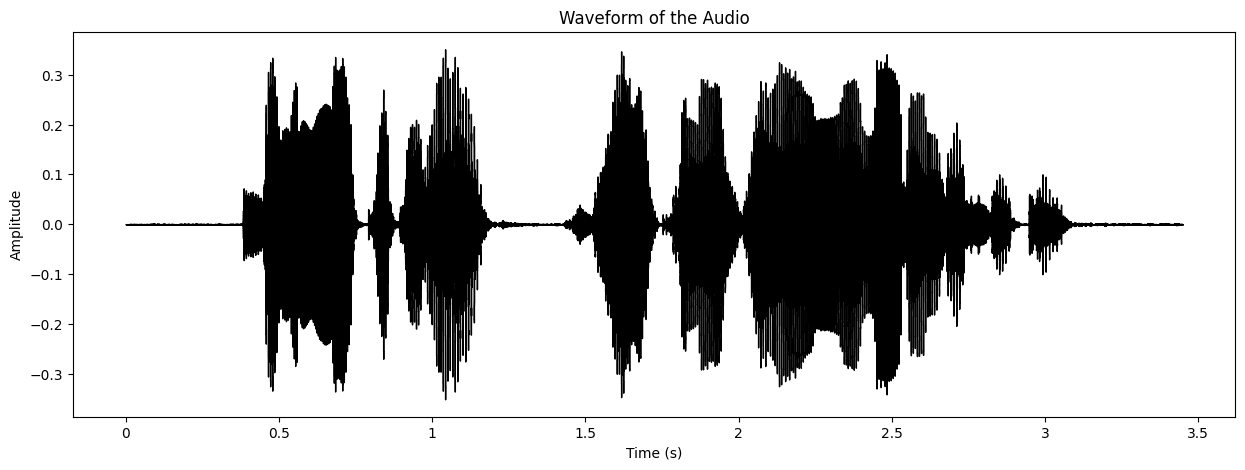

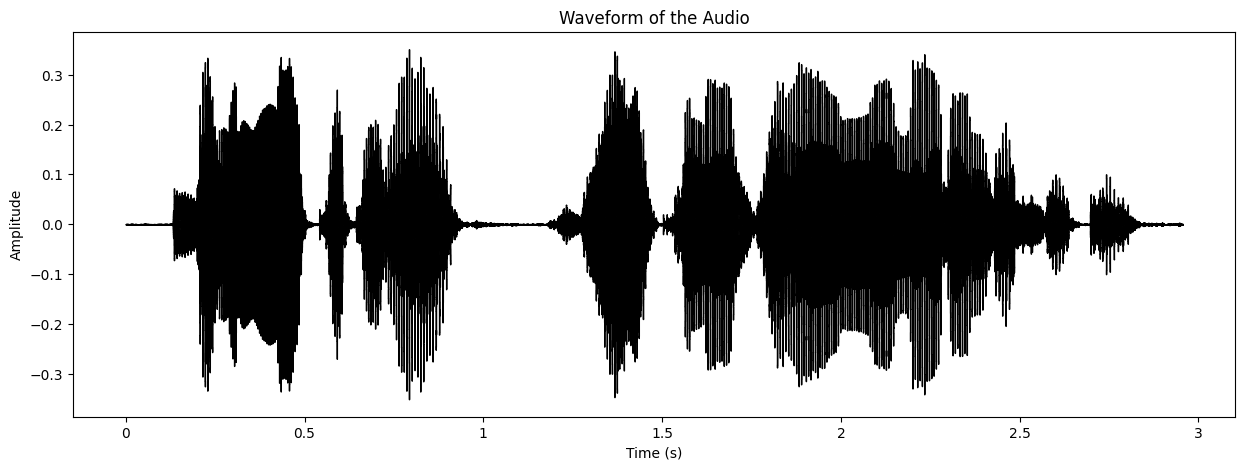

In [222]:
# 時系列のプロット
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sr, color="#000000")
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
# 時系列のプロット
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x_cut, sr=sr, color="#000000")
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [223]:
# wav_file = "../downloads/hfc_men/all/Seikatsu01_B-A__000040.wav"
wav_file = "../../test_tacotron2/downloads/jsut_ver1.1/basic5000/wav/BASIC5000_0001.wav"
# lab_file = "../downloads/hfc_men-label/all/Seikatsu01_B-A__000040.lab"
lab_file = "../../test_tacotron2/downloads/jsut-label/labels/basic5000/BASIC5000_0001.lab"

In [224]:
# assert wav_file.stem == lab_file.stem  # assertは例外処理 Falseの場合 error
labels = hts.load(lab_file) #ラベル情報を解析し読み込む ( テキストではなくすでにフルコンテキストとなっている )
# 韻律記号付き音素列の抽出
PP = pp_symbols(labels.contexts) 
in_feats = np.array(text_to_sequence(PP), dtype=np.int64) # PPの記号と文字を、辞書と照らし合わせて数値に割り当ててく

# tacotron出力特徴量 ( メルスペクトロゴラム ) : メルスペクトログラムの計算
_sr, x = wavfile.read(wav_file) #scipyによって音声を読み込む
if x.dtype in [np.int16, np.int32]: #振幅度指標を取得
    x = (x / np.iinfo(x.dtype).max).astype(np.float64) #サンプル値を正規化
x = librosa.resample(x, orig_sr=_sr, target_sr=sr) #設定したいサンプルレートにリサンプル
out_feats = logmelspectrogram(x, sr) #メルスペクトログラムを計算

# 冒頭と末尾の非音声区間の長さを調整 ( 無音期間を切り詰める )
assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1] #ラベルのフルコンテキストの先頭と末尾に無音区間( sil )があるか確認
start_frame = int(labels.start_times[1] / 125000) #第一音素が出るまでの期間のサンプル数を取得
end_frame = int(labels.end_times[-2] / 125000)

# 冒頭： 50 ミリ秒、末尾： 100 ミリ秒
start_frame = max(0, start_frame - int(0.050 / 0.0125)) #最初の無音が50msより多い場合にはその差分をそれ以外は０を取得
end_frame = min(len(out_feats), end_frame + int(0.100 / 0.0125))
out_feats_cut = out_feats[start_frame:end_frame] #余分な無音部分を切り詰める

In [225]:
x_cut = x[int(start_frame * 0.0125 * sr) :]
length = int(sr * 0.0125) * out_feats_cut.shape[0]
x_cut = pad_1d(x_cut, length) if len(x) < length else x_cut[:length] # 無音期間が足りない場合にはpaddingして、多い場合には切り出す

In [226]:
print("before cut frame is : " + str(out_feats.shape[0]))
print("cutted frame is : " + str(out_feats_cut.shape[0]))

before cut frame is : 256
cutted frame is : 227


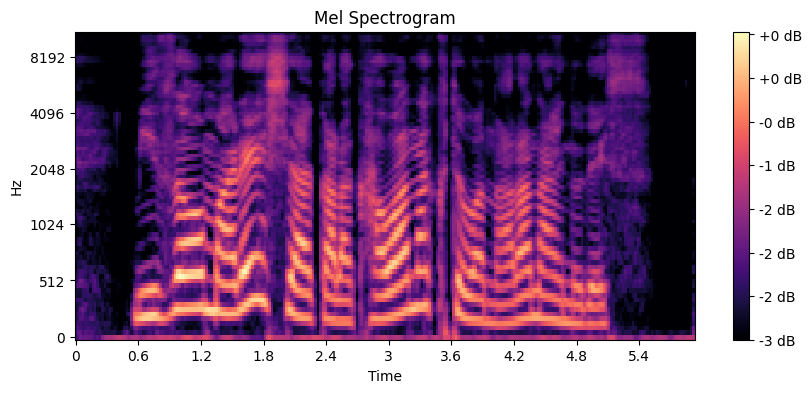

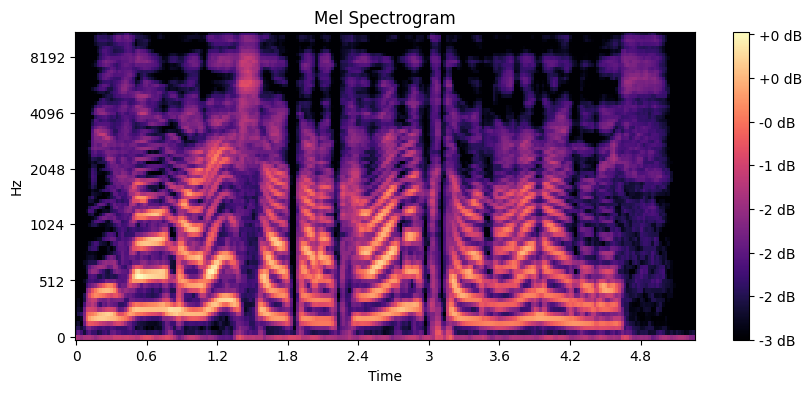

In [227]:
# メルスペクトログラムを描画
plt.figure(figsize=(10, 4))
librosa.display.specshow(out_feats.T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()
# メルスペクトログラムを描画
plt.figure(figsize=(10, 4))
librosa.display.specshow(out_feats_cut.T, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

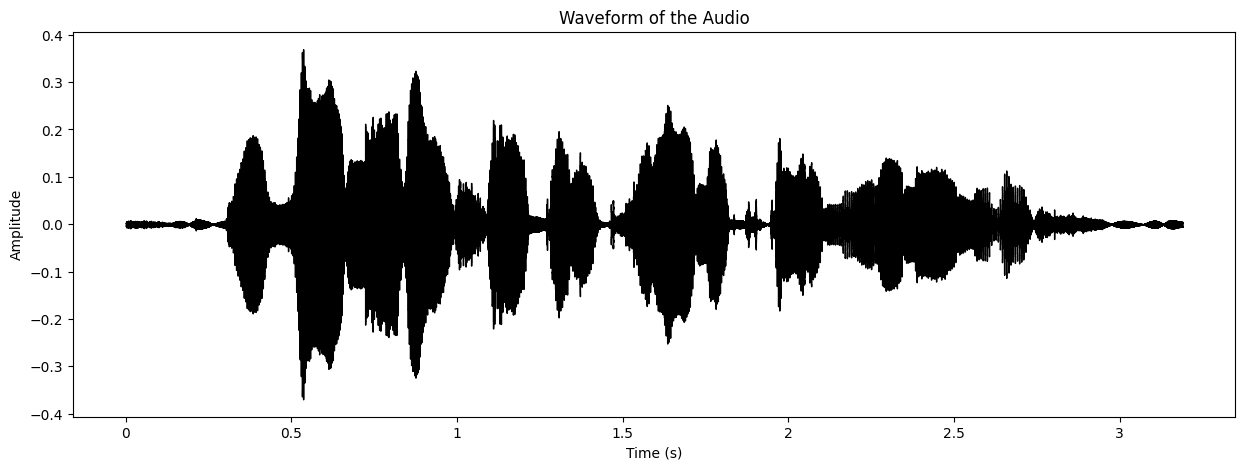

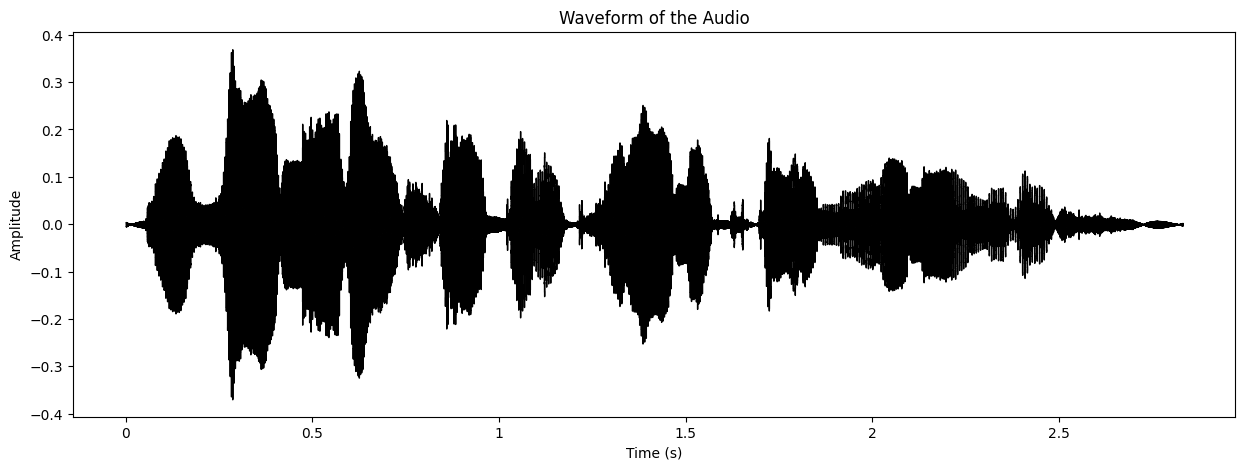

In [214]:
# 時系列のプロット
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sr, color="#000000")
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
# 時系列のプロット
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x_cut, sr=sr, color="#000000")
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()